In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import graph_tool as gt
from graph_tool import draw, centrality, clustering, topology
import pandas as pd
import numpy as np
import scipy
import json

ModuleNotFoundError: No module named 'graph_tool'

## Загрузка графа

In [ ]:
df = pd.read_csv('data/graph.csv', header=None)
df.head()

In [ ]:
def create_mapping(edges):
    mapping = {}
    mapping_reverse = {}
    mapped_edges = []
    
    i = 0
    for edge in edges:
        for v in edge:
            if v not in mapping:
                mapping[v] = i
                mapping_reverse[i] = v
                i += 1
        mapped_edges.append((mapping[edge[0]], mapping[edge[1]]))
    
    return mapped_edges, mapping, mapping_reverse

In [2]:
edges = [tuple(x) for x in df.iloc[:,:2].values]
weights = df.iloc[:,2].tolist()

NameError: name 'df' is not defined

In [3]:
mapped_edges, mapping, mapping_reverse = create_mapping(edges)

NameError: name 'create_mapping' is not defined

In [6]:
g = gt.Graph(directed=False)
e_weight = g.new_edge_property("float")

In [7]:
g.add_edge_list(mapped_edges)
e_weight.a = weights

## Визуализация

In [8]:
pos = gt.draw.sfdp_layout(g, verbose=True, max_iter=10)

Coarse level (EC): 2  num vertices: 38159
Coarse level (EC): 3  num vertices: 19689
Coarse level (EC): 4  num vertices: 10595
Coarse level (EC): 5  num vertices: 6026
Coarse level (EC): 6  num vertices: 3758
Coarse level (EC): 7  num vertices: 2628
Coarse level (MIVS): 8  num vertices: 2068
Coarse level (MIVS): 9  num vertices: 1576
Positioning level: 0 1576 with K = 19.758280817375123 ...
avg edge distance: 18.00155143719719
propagating... 1576
Positioning level: 1 2068 with K = 14.818710613031342 ...
avg edge distance: 16.32380697704315
propagating... 
Positioning level: 2 2628 with K = 11.114032959773507 ...
avg edge distance: 13.75596880668844
propagating... 
Positioning level: 3 3758 with K = 8.33552471983013 ...
avg edge distance: 11.6984607114788
propagating... 
Positioning level: 4 6026 with K = 6.251643539872597 ...
avg edge distance: 9.327598151655973
propagating... 
Positioning level: 5 10595 with K = 4.688732654904448 ...
avg edge distance: 7.147780009516666
propagating... 

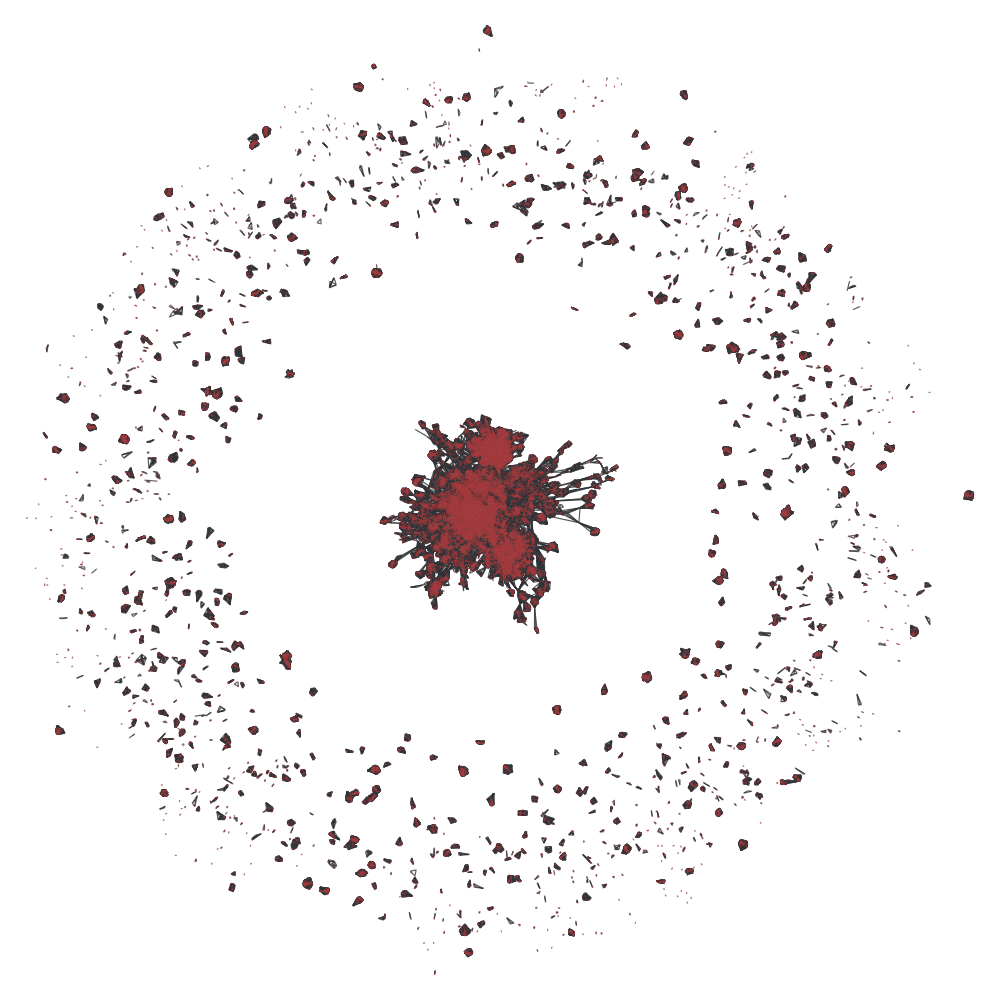

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1a4035bd30, at 0x11a38b710>

In [9]:
gt.draw.graph_draw(g, pos, output_size=(1000, 1000), vertex_size=1, edge_pen_width=1.2, vcmap=matplotlib.cm.gist_heat_r)

## Анализ графа

In [10]:
print('Order: {}, size: {}'.format(g.num_vertices(), g.num_edges()))

Order: 74757, size: 7695123


In [11]:
comp, comp_hist = gt.topology.label_components(g)

In [12]:
n_comp = len(comp_hist)
print('Number of Connected Components: {}'.format(n_comp))

Number of Connected Components: 1392


In [20]:
sorted(comp_hist, reverse=True)[:10]

[57319, 302, 281, 271, 211, 173, 168, 163, 159, 149]

In [76]:
gc_index = np.argmax(comp_hist)
gc = gt.GraphView(g, vfilt=comp.a == gc_index)

In [66]:
print('Greatest Connected Component - Order: {}, size: {}'.format(gc.num_vertices(), gc.num_edges()))

Greatest Connected Component - Order: 57319, size: 7278685


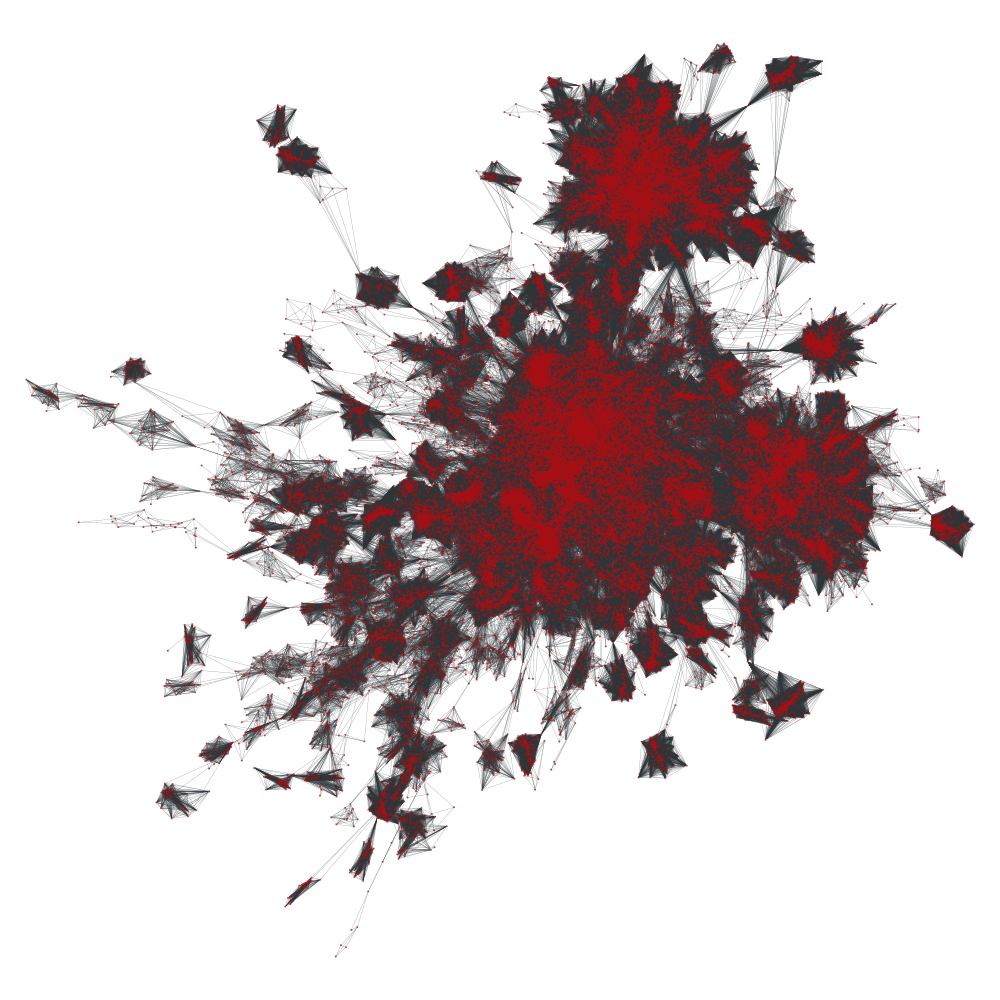

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1a5149ce10, at 0x1a514bdf28>

In [17]:
pos_gc = gt.draw.sfdp_layout(gc, max_iter=10)
gt.draw.graph_draw(gc, pos_gc, output_size=(1000, 1000), vertex_size=2, vcmap=matplotlib.cm.gist_heat_r,
           edge_pen_width=0.2, vertex_color=[1,1,1,0])

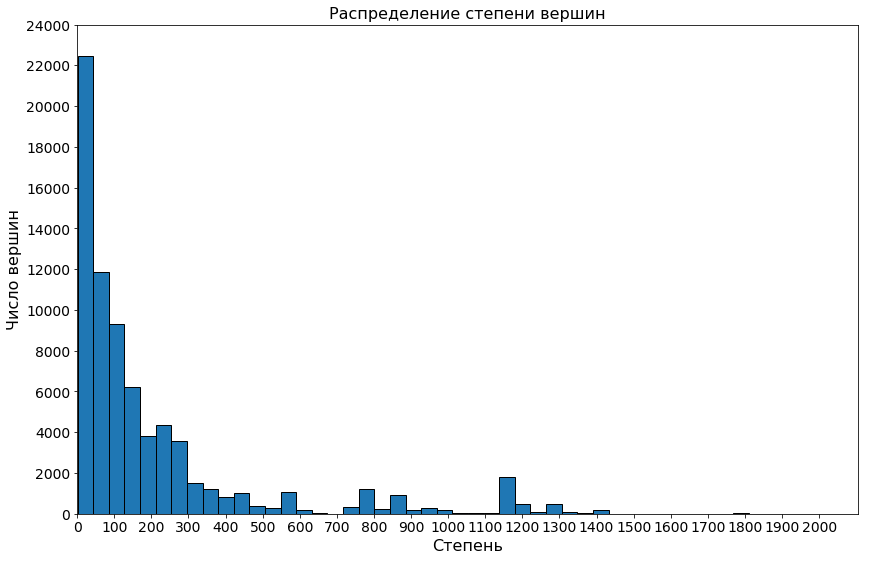

In [72]:
deg = g.degree_property_map('total').a

plt.figure(figsize=(14, 9))
plt.hist(deg, ec='black', bins=50)
plt.xticks([i * 100 for i in range(21)], fontsize=14)
plt.yticks([i * 1000 for i in range(0, 31, 2)], fontsize=14)
plt.xlim(0, max(deg))
plt.ylim(0, 24000)
plt.xlabel('Степень', fontsize=16)
plt.ylabel('Число вершин', fontsize=16)
plt.title('Распределение степени вершин', fontsize=16)
plt.show()

In [19]:
diameter = gt.topology.pseudo_diameter(gc)[0]
clustering = gt.clustering.global_clustering(gc)[0]

In [23]:
print('Diameter: {}, Clustering Coefficient: {:.2f}'.format(diameter, clustering))

Diameter: 21.0, Clustering Coefficient: 0.91


In [167]:
pairs_subsample = np.random.choice(list(gc.vertices()), (100000, 2))

In [168]:
shortest_paths = []

for pair in pairs_subsample:
    shortest_paths.append(gt.topology.shortest_distance(gc, source=pair[0], target=pair[1]))

In [170]:
len(shortest_paths)

100000

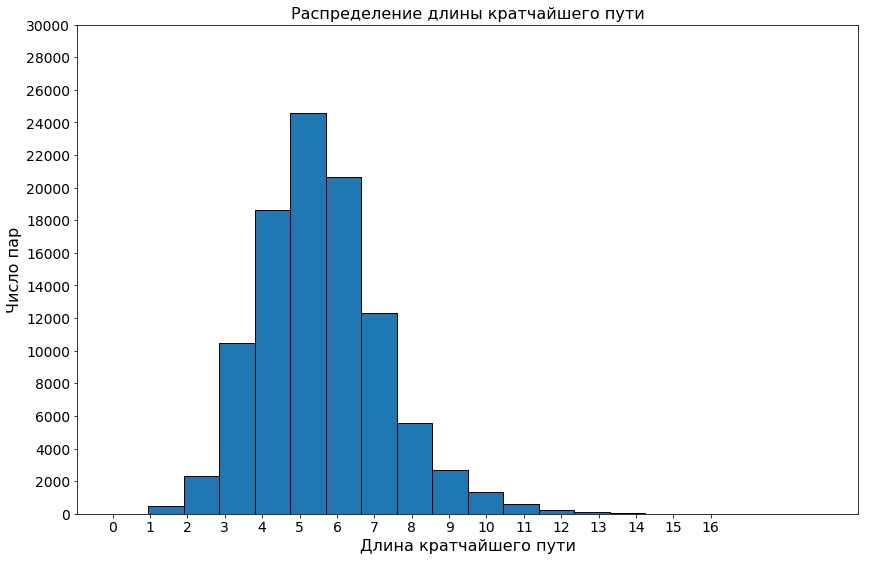

In [178]:
plt.figure(figsize=(14, 9))
plt.hist(shortest_paths, ec='black', bins=20)
plt.xlabel('Длина кратчайшего пути', fontsize=16)
plt.ylabel('Число пар', fontsize=16)
plt.xticks([i for i in range(17)], fontsize=14)
plt.yticks([i * 1000 for i in range(0, 31, 2)], fontsize=14)
plt.title('Распределение длины кратчайшего пути', fontsize=16)
plt.show()

## Центральности

In [99]:
def centr_to_json(centr, mapping_reverse, name):
    res = {}
    for i, v in enumerate(centr):
        res[mapping_reverse[i]] = v
        
    with open('data/{}_centrality.json'.format(name), 'w') as out_file:
        tmp = {str(k): round(res[k], 3) for k in res}
        json.dump(tmp, out_file)
    
    return res

### Degree

In [100]:
deg_centr = deg / (len(deg) - 1)

In [102]:
_ = centr_to_json(deg_centr, mapping_reverse, 'degree')

### Betweenness

In [33]:
vertex_betw, edge_betw = gt.centrality.betweenness(g)

In [106]:
betw_centr = vertex_betw.a

In [107]:
_ = centr_to_json(betw_centr, mapping_reverse, 'betweenness')

### Pagerank

In [179]:
pagerank = gt.centrality.pagerank(g)

In [184]:
pagerank_centr = pagerank.a

In [185]:
_ = centr_to_json(pagerank_centr, mapping_reverse, 'pagerank')

### Closeness

In [186]:
closeness = gt.centrality.closeness(g)

In [187]:
closeness_centr = closeness.a

In [188]:
_ = centr_to_json(closeness_centr, mapping_reverse, 'closeness')

## Корреляция дохода и центральностей

In [131]:
with open('data/officials.json') as inp_file:
    officials_dict = json.load(inp_file)

In [132]:
officials_df = pd.DataFrame.from_dict(officials_dict, orient='index').reset_index()
officials_df.columns = ['person_id', 'person_name', 'income']
officials_df['person_id'] = officials_df['person_id'].astype(int)
officials_df['person_id'] = officials_df['person_id'].map(mapping)
officials_df = officials_df.dropna()
officials_df['person_id'] = officials_df['person_id'].astype(int)
officials_df.head()

,person_id,person_name,income
0,2,Андреев Андрей Анатольевич,2.962840e+07
1,91,Островский Алексей Владимирович,1.419963e+08
2,8017,Тихонов Валерий Владимирович,5.039890e+07
3,20795,Шипилова Светлана Андреевна,7.284374e+06
14,20796,Шутова Валентина Михайловна,5.999317e+06


In [133]:
officials_df = officials_df.sort_values(by='person_id').reset_index(drop=True)
officials_df.head()

,person_id,person_name,income
0,0,Зюганов Геннадий Андреевич,5.791525e+07
1,1,Алферов Жорес Иванович,1.601186e+08
2,2,Андреев Андрей Анатольевич,2.962840e+07
3,3,Апарина Алевтина Викторовна,1.049138e+07
4,4,Афонин Юрий Вячеславович,6.922374e+07


In [198]:
centr_names = ['degree', 'betweenness', 'pagerank', 'closeness']
centralities = [deg_centr, betw_centr, pagerank_centr, closeness_centr]

In [199]:
print('Pearson:')
for name, centr in zip(centr_names, centralities):
    print(name, scipy.stats.pearsonr(income, centr))

Pearson:
degree (0.01309545590355725, 0.0003427833256649658)
betweenness (0.0045722015408221, 0.21126138938252353)
pagerank (0.011083103590704382, 0.0024426705261229643)
closeness (-0.005548000603850126, 0.12929055701072636)


In [201]:
print('Spearman:')
for name, centr in zip(centr_names, centralities):
    print(name, scipy.stats.spearmanr(income, centr))

Spearman:
degree SpearmanrResult(correlation=0.1032865170856719, pvalue=2.2209628341342225e-176)
betweenness SpearmanrResult(correlation=0.4787527555359573, pvalue=0.0)
pagerank SpearmanrResult(correlation=0.25527950594922727, pvalue=0.0)
closeness SpearmanrResult(correlation=0.06913999219141675, pvalue=6.912599539979866e-80)
